### satellite comparison

creating loop which will compare number of tracks in true vs number of tracks in beersheba deconvolved.

In [1]:
import sys,os,os.path
#sys.path.append("../../")   # cite IC from parent directory
sys.path.append("/gluster/data/next/software/IC_satkill/")
#sys.path.append("/gluster/data/next/software/IC_sophronia/")
#sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
os.environ['ICTDIR']='/gluster/data/next/software/IC_satkill/'


#%load_ext autoreload
#%autoreload 2
#%matplotlib notebook

import time

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['mathtext.fontset'] = 'stix'
rcParams['font.family'] = 'STIXGeneral'
rcParams['figure.figsize'] = [10, 8]
rcParams['font.size'] = 22

import pandas as pd
import numpy  as np
import tables as tb

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as clrs
from matplotlib.lines import Line2D


import IC.invisible_cities.core.core_functions                   as     coref
import IC.invisible_cities.io.dst_io                           as     dstio

from IC.invisible_cities.cities                 import beersheba as beerfun

from IC.invisible_cities.evm.event_model                          import HitCollection

from IC.invisible_cities.database.load_db       import DataSiPM

from IC.invisible_cities.evm.event_model        import Cluster, Hit
from IC.invisible_cities.types.ic_types         import xy
from IC.invisible_cities.reco.paolina_functions import voxelize_hits, drop_end_point_voxels, make_track_graphs, get_track_energy

from IC.invisible_cities.evm.event_model        import HitEnergy
from IC.invisible_cities.cities.beersheba          import DeconvolutionMode
from IC.invisible_cities.cities.beersheba          import CutType

from IC.invisible_cities.reco import hits_functions as hif

from IC.invisible_cities.reco.deconv_functions import deconvolve
from IC.invisible_cities.reco.deconv_functions import deconvolution_input
from IC.invisible_cities.reco.deconv_functions import InterpolationMethod

import IC.invisible_cities.io.mcinfo_io as mcio

from collections import defaultdict

import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.lines import Line2D




def threshold_hits(threshold_charge, same_peak, hitc):
    """
    Applies a threshold to hits and redistributes the charge/energy.

    Parameters
    ----------
    threshold_charge : float
        minimum pes of a hit
    same_peak        : bool
        whether to reassign NN hits' energy only to the hits from the same peak

    Returns
    ----------
    A function that takes HitCollection as input and returns another object with
    only non NN hits of charge above threshold_charge.
    The energy of NN hits is redistributed among neighbors.
    """

    t = hitc.time
    thr_hits = hif.threshold_hits(hitc.hits, threshold_charge     )
    mrg_hits = hif.merge_NN_hits ( thr_hits, same_peak = same_peak)

    cor_hits = []
    for hit in mrg_hits:
        cluster = Cluster(hit.Q, xy(hit.X, hit.Y), hit.var, hit.nsipm)
        xypos   = xy(hit.Xpeak, hit.Ypeak)
        hit     = Hit(hit.npeak, cluster, hit.Z, hit.E, xypos, hit.Ec)
        cor_hits.append(hit)

    new_hitc      = HitCollection(hitc.event, t)
    new_hitc.hits = cor_hits
    return new_hitc





def hits_from_df (dst, skip_NN = False):
    """
    Function that transforms pandas DataFrame dst to HitCollection
    ------
    Parameters
    ------
    dst : pd.DataFrame
        DataFrame with obligatory columns :
                event, npeak, X, Y, Z,  Q, E
        If time, nsipm, Xrms, Yrms, Qc, Ec, track_id are not
        inside dst the default value is set to -1
        If Xpeak, Ypeak not in dst the default value is -1000
    ------
    Returns
    ------
    Dictionary {event_number : HitCollection}
    from here
    https://github.com/next-exp/IC/blob/v2-development/invisible_cities/io/hits_io.py#L16
    """
    all_events = {}
    times = getattr(dst, 'time', [-1]*len(dst))
    for (event, time) , df in dst.groupby(['event', times]):
        #pandas is not consistent with numpy dtypes so we have to change it by hand
        event = np.int32(event)
        hits  = []
        for i, row in df.iterrows():
            Q = getattr(row,'Q', row.E)
            if skip_NN and Q == NN:
                continue
            if hasattr(row, 'Xrms'):
                Xrms  = row.Xrms
                Xrms2 = Xrms**2
            else:
                Xrms = Xrms2 = -1
            if hasattr(row, 'Yrms'):
                Yrms  = row.Yrms
                Yrms2 = Yrms**2
            else:
                Yrms = Yrms2 = -1
            nsipm   = getattr(row, 'nsipm'   , -1   )     # for backwards compatibility
            Qc      = getattr(row, 'Qc'      , -1   )     # for backwards compatibility
            Xpeak   = getattr(row, 'Xpeak'   , -1000)     # for backwards compatibility
            Ypeak   = getattr(row, 'Ypeak'   , -1000)     # for backwards compatibility
            Ec      = getattr(row, 'Ec'      , -1   )     # for backwards compatibility
            trackID = getattr(row, 'track_id', -1   )     # for backwards compatibility
            Ep      = getattr(row, "Ep"      , -1   )     # for backwards compatibility

            hit = Hit(row.npeak            ,
                      Cluster(Q               ,
                              xy(row.X, row.Y),
                              xy(Xrms2, Yrms2),
                              nsipm = nsipm   ,
                              z     = row.Z   ,
                              E     = row.E   ,
                              Qc    = Qc      ),
                      row.Z                ,
                      row.E                ,
                      xy(Xpeak, Ypeak)     ,
                      s2_energy_c = Ec     ,
                      track_id    = trackID,
                      Ep          = Ep     )

            hits.append(hit)

        if len(hits):
            all_events[event] = HitCollection(event, time, hits=hits)

    return all_events

def hitc_to_df_(hitc):
    columns = defaultdict(list)
    for hit in hitc.hits:
        columns["event"   ].append(hitc.event)
        columns["time"    ].append(hitc.time)
        columns["npeak"   ].append(hit .npeak)
        columns["Xpeak"   ].append(hit .Xpeak)
        columns["Ypeak"   ].append(hit .Ypeak)
        columns["nsipm"   ].append(hit .nsipm)
        columns["X"       ].append(hit .X)
        columns["Y"       ].append(hit .Y)
        columns["Xrms"    ].append(hit .Xrms)
        columns["Yrms"    ].append(hit .Yrms)
        columns["Z"       ].append(hit .Z)
        columns["Q"       ].append(hit .Q)
        columns["E"       ].append(hit .E)
        columns["Qc"      ].append(hit .Qc)
        columns["Ec"      ].append(hit .Ec)
        columns["track_id"].append(hit .track_id)
        columns["Ep"      ].append(hit .Ep)
    return pd.DataFrame(columns)






def soph_to_lowTh(df, threshold = 5):
    '''
    Converts sophronia 'RECO/Events' to lowTh events via a rather convoluted process
    Made by me (John Waiton), so dont treat it like a normal function from IC!
    ------
    Parameters
    ------
    df : pd.DataFrame
        DataFrame with obligatory columns :
                event, npeak, X, Y, Z,  Q, E
    threshold: int
        value at which the threshold is set.
    ------
    Returns
    ------
    Dictionary {event_number : HitCollection}
    from here
    '''

    # safety check, to ensure you don't accidentally make a repeating dataframe
    


    # new parameters for threshold, this is silly but I'm copying previous convention
    pes = 1
    threshold = threshold * pes
    same_peak = True

    # convert sophronia RECO/Events to hit collection
    soph_hitc = hits_from_df(df)

    # collect the keys as the event numbers
    soph_hitc_list = list(soph_hitc.keys())

    print("Processing data...")
    # loop over all of these events
    j = 0
    for i in soph_hitc_list:
        j += 1

        if (len(soph_hitc_list)%j == 50): 
            print("{}/{}".format(j, len(soph_hitc_list)))
        # choose i'th event
        soph_hit_event = soph_hitc.get(i)

        # Apply threshold calculation
        soph_hitc_lowTh = threshold_hits(threshold, same_peak, soph_hit_event)

        # convert back to pandas dataframe using hitc_to_df
        soph_hdst_lowTh = hitc_to_df_(soph_hitc_lowTh)

        # check if pandas dataframe with all the events exists yet
        if 'full_soph_df' in locals() and isinstance(full_soph_df, pd.DataFrame):
            full_soph_df = pd.concat([full_soph_df, soph_hdst_lowTh])
        else:
            full_soph_df = soph_hdst_lowTh.copy(deep = True)
    
    return full_soph_df


def collect_min_max_bins(hits):
    '''
    returns all the min, max and mid values you'd need
    as well as the bins
    '''
    x_range = (hits.X.max()-hits.X.min())/2.
    y_range = (hits.Y.max()-hits.Y.min())/2.
    z_range = (hits.Z.max()-hits.Z.min())/2.
    mid_x   = (hits.X.max()+hits.X.min())/2.
    mid_y   = (hits.Y.max()+hits.Y.min())/2.
    mid_z   = (hits.Z.max()+hits.Z.min())/2.
    min_x = hits.X.min()
    min_y = hits.Y.min()
    min_z = hits.Z.min()

    max_x = hits.X.max()
    max_y = hits.Y.max()
    max_z = hits.Z.max()
    #print("X maximum and minimum")
    #print(max_x, min_x)
    #print("")

    #print("Y maximum and minimum")
    #print(max_y, min_y)
    #print("")

    #print("Z maximum and minimum")
    #print(max_z, min_z)

    xbins = int(hits.X.max()-hits.X.min())
    ybins = int(hits.Y.max()-hits.Y.min())
    zbins = int((hits.Z.max()-hits.Z.min())/2.)
    
    array = [x_range, y_range, z_range, mid_x, mid_y, mid_z, min_x, min_y, min_z, max_x, max_y, max_z, xbins, ybins, zbins]
    
    return (array)



def return_id(number):
    return str(df_ps[df_ps.particle_id == number].particle_name.values).strip("'[]'")


def count_tracks_mc(hits_deco):
   
    # stuff needed for paolina track counting
    energy_threshold = 10
    min_voxels = 3
    
    base_vsize = 12 #mm
    the_hits = []

    xs = hits_deco.x
    ys = hits_deco.y
    zs = hits_deco.z
    es = hits_deco.energy

    for x, y, z, e in zip(xs, ys, zs, es):
        if np.isnan(e): continue
        h = Hit(0, Cluster(0, xy(x,y), xy(0,0), 0), z, e*1000, xy(0,0))
        the_hits.append(h)

    voxels = voxelize_hits(the_hits,
                           np.array([base_vsize, base_vsize, base_vsize]), False)

    (mod_voxels, dropped_voxels) = drop_end_point_voxels(voxels, energy_threshold, min_voxels)

    
    tracks = make_track_graphs(mod_voxels)
    tracks = sorted(tracks, key=get_track_energy, reverse = True)
    
    track_no = 0
    for c, t in enumerate(tracks, 0):
        track_no += 1
    
    return track_no    


def count_tracks(hits_deco):
    
    
    
    # stuff needed for paolina track counting
    energy_threshold = 10
    min_voxels = 3
    
    base_vsize = 12 #mm
    the_hits = []

    xs = hits_deco.X
    ys = hits_deco.Y
    zs = hits_deco.Z
    es = hits_deco.E

    for x, y, z, e in zip(xs, ys, zs, es):
        if np.isnan(e): continue
        h = Hit(0, Cluster(0, xy(x,y), xy(0,0), 0), z, e*1000, xy(0,0))
        the_hits.append(h)

    voxels = voxelize_hits(the_hits,
                           np.array([base_vsize, base_vsize, base_vsize]), False)

    (mod_voxels, dropped_voxels) = drop_end_point_voxels(voxels, energy_threshold, min_voxels)

    
    tracks = make_track_graphs(mod_voxels)
    tracks = sorted(tracks, key=get_track_energy, reverse = True)
    
    track_no = 0
    for c, t in enumerate(tracks, 0):
        track_no += 1
    
    return track_no

#### RELEVANT PARAMETERS


# set q_thr value here
thresh = 4

# Decides if plots are limited by the MC true info
lim_toggle = True


# limits
limit_spacing = 50 # put in the number required division-wise to produce a percentage
                    # eg: 10% of min and max means /10, 50% means /2

# Input file and some event IDs to look at.
dist = 12
typefile = 'esmeralda' #'esmeralda'
#file = f'/Users/halmamol/NEXT/files/NEXT100/separated/esmeralda/esmeralda_10_sep.h5'
#file = f'../../../Tl_studies/LPR/208Tl/PORT_2a/prod/esmeralda/esmeralda_180_208Tl.h5'
#file = f'/Users/halmamol/NEXT/files/FLEX/ELdistMask/Xe/bb0nu/{typefile}/NextFlex.bb0nu.FLEXELdist{dist}mask.0.detsim.h5'
evts = [90] #15, 30, 90
pitch = 15.55
detector_db     = '/gluster/data/next/software/IC_satkill/IC/invisible_cities/database/localdb.NEXT100DB.sqlite3'
run_number      = -1

datatype = 'MC'


# Parameters involved in beersheba city and the deconvolution.

'''
## FROM OLD TESTING
deconv_params = dict(
  q_cut           = 5, #5 for 6mm  - 5 for 6mm
  drop_dist       = [16, 16],
  #psf_fname       = f'/Users/halmamol/NEXT/PSF_FLEX100_mask{dist}_lowQE.h5',     
  psf_fname       = f'../data/data/LightTables/NEXT100_PSF_kr83m.h5',     
  e_cut           = 6e-3, #15 for 6mm  - 15 for 6mm
  n_iterations    = 100, #150 for 6mm  - 150 for 6mm
  iteration_tol   = 1e-10,
  sample_width    = [15.55, 15.55],
  bin_size        = [ 1,  1],
  diffusion       = (1., 0.2),
  n_dim           = 2,
  deconv_mode     = DeconvolutionMode.joint)#,
 # energy_type     = HitEnergy.Ec,
 # cut_type        = CutType.abs,
 # inter_method    = InterpolationMethod.cubic)
'''

# new parameters for threshold
pes = 1
threshold = thresh * pes
same_peak = True

deconv_params = dict(
                  drop_dist       = [16., 16.],
                  psf_fname       = f'/gluster/data/next/files/TOPOLOGY_John/LPR/LightTables/NEXT100_PSF_kr83m_5bar.h5',
                  q_cut           = thresh,                   # WE HAVE MANUALLY CHANGED THIS FROM 10 -> 5 HERE
                  e_cut           = 9e-3,                # WE HAVE MANUALLY CHANGED THIS FROM 12e-3 TO 6e-3
                  n_iterations    = 80,
                  iteration_tol   = 1e-10,
                  sample_width    = [15.55, 15.55],
                  bin_size        = [ 1.,  1.],
                  satellite_iter  = 5, # after how many iterations do you start scanning? 
                  satellite_dist  = 10,
                  satellite_size  = 10,
                  energy_type     = HitEnergy.Ec,               #Removing these variables because they were previously? 
                  diffusion       = (1.440, 1.440),
                  deconv_mode     = DeconvolutionMode.joint,
                  n_dim           = 2,
                  cut_type        = CutType.abs,              #Removing these variables because they were previously?
                  inter_method    = InterpolationMethod.cubic)            #Removing these variables because they were previously?  






#DeconvolutionMode
                
deconv_params_   = {k : v for k, v in deconv_params.items() if k not in ['q_cut', 'drop_dist']}

# Couple of functions used in beersheba.
cut_sensors       = beerfun.cut_over_Q   (deconv_params['q_cut'    ], ['E', 'Ec'])
drop_sensors      = beerfun.drop_isolated(deconv_params['drop_dist'], ['E', 'Ec'])

In [3]:
folder_path = f'/gluster/data/next/files/TOPOLOGY_John/HYPPOS_DATA_QTHR/Q_THR4/PORT_1a/sophronia/'
file_names = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) and f.endswith('.h5')]
print(file_names[1])


sophronia_7_208Tl.h5


In [ ]:


#for file in file_names:
#    # load sophronia file
#    soph_file = folder_path + file
#    dstio.load_dst(soph_file, 'RECO', 'Events')
#    
#    hdst = soph_to_lowTh(soph_hdst, threshold = thresh)


In [4]:
# loading sophronia file
#soph_file = f'../../../next_misc/Tl_studies/sophronia/sophronia_qthr2.h5'
soph_file = f'/gluster/data/next/files/TOPOLOGY_John/HYPPOS_DATA_QTHR/Q_THR4/PORT_1a/sophronia/sophronia_27_208Tl.h5'
soph_hdst = dstio.load_dst(soph_file, 'RECO', 'Events')#CHITS/lowTh

# Name of directory the plots are going into
#pre_dir_name = 'qthr2_plot/'

# set q_thr value here
thresh = 4

# Decides if plots are limited by the MC true info
lim_toggle = True


# limits
limit_spacing = 50 # put in the number required division-wise to produce a percentage
                    # eg: 10% of min and max means /10, 50% means /2

display(soph_hdst)

,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep
0,520000,5.200012e+11,0,237.823620,-217.509278,1,225.475,-225.475,0.0,0.0,369.512128,5.101449,236.734026,-1.0,0.000766,-1,-1.0
1,520000,5.200012e+11,0,237.823620,-217.509278,1,225.475,-209.925,0.0,0.0,369.512128,10.144928,470.777938,-1.0,0.001512,-1,-1.0
2,520000,5.200012e+11,0,237.823620,-217.509278,1,241.025,-241.025,0.0,0.0,369.512128,4.811594,223.283232,-1.0,0.000741,-1,-1.0
3,520000,5.200012e+11,0,237.823620,-217.509278,1,241.025,-225.475,0.0,0.0,369.512128,13.913044,645.638310,-1.0,0.002115,-1,-1.0
4,520000,5.200012e+11,0,237.823620,-217.509278,1,241.025,-209.925,0.0,0.0,369.512128,18.144928,842.019953,-1.0,0.002748,-1,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147151,520640,5.206420e+11,1,347.356042,323.206374,1,349.875,318.775,0.0,0.0,670.050544,5.913043,188.888896,-1.0,0.000849,-1,-1.0
147152,520640,5.206420e+11,1,347.356042,323.206374,1,349.875,334.325,0.0,0.0,670.050544,5.275362,168.518515,-1.0,0.000608,-1,-1.0
147153,520640,5.206420e+11,1,347.356042,323.206374,1,365.425,318.775,0.0,0.0,670.050544,6.492754,207.407411,-1.0,0.001296,-1,-1.0
147154,520640,5.206420e+11,1,347.356042,323.206374,1,365.425,334.325,0.0,0.0,670.050544,4.521739,144.444446,-1.0,0.000521,-1,-1.0


In [6]:
#hdst = soph_to_lowTh(soph_hdst, threshold = thresh)
hdst = soph_hdst

In [6]:
evt = hdst.event.unique()[7]
hits = hdst[hdst.event == evt]

file_number = 27
dir_name = "Tl208_" + str(file_number) + "_event_" + str(int(evt/2))

In [8]:
x_range = (hits.X.max()-hits.X.min())/2.
y_range = (hits.Y.max()-hits.Y.min())/2.
z_range = (hits.Z.max()-hits.Z.min())/2.
mid_x   = (hits.X.max()+hits.X.min())/2.
mid_y   = (hits.Y.max()+hits.Y.min())/2.
mid_z   = (hits.Z.max()+hits.Z.min())/2.
min_x = hits.X.min()
min_y = hits.Y.min()
min_z = hits.Z.min()

max_x = hits.X.max()
max_y = hits.Y.max()
max_z = hits.Z.max()
print("X maximum and minimum")
print(max_x, min_x)
print("")

print("Y maximum and minimum")
print(max_y, min_y)
print("")

print("Z maximum and minimum")
print(max_z, min_z)

xbins = int(hits.X.max()-hits.X.min())
ybins = int(hits.Y.max()-hits.Y.min())
zbins = int((hits.Z.max()-hits.Z.min())/2.)


X maximum and minimum
443.175 -272.125

Y maximum and minimum
225.475 -396.525

Z maximum and minimum
300.13301718750006 250.91151093750003


In [9]:
if (datatype == 'MC'):
    evtmap = mcio.load_eventnumbermap(soph_file).set_index('nexus_evt')
    true_info = mcio.load_mchits_df(soph_file).reset_index()
    true_info.event_id = true_info.event_id.map(evtmap.evt_number)
    
    
    this_evt_true_info = true_info[true_info.event_id == evt]

    xt = this_evt_true_info.x
    yt = this_evt_true_info.y
    zt = this_evt_true_info.z
    et = this_evt_true_info.energy*1000

In [25]:
num_mc = count_tracks_mc(this_evt_true_info)
print(num_mc)

1


/tmp/ipykernel_899192/2818632070.py:57: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


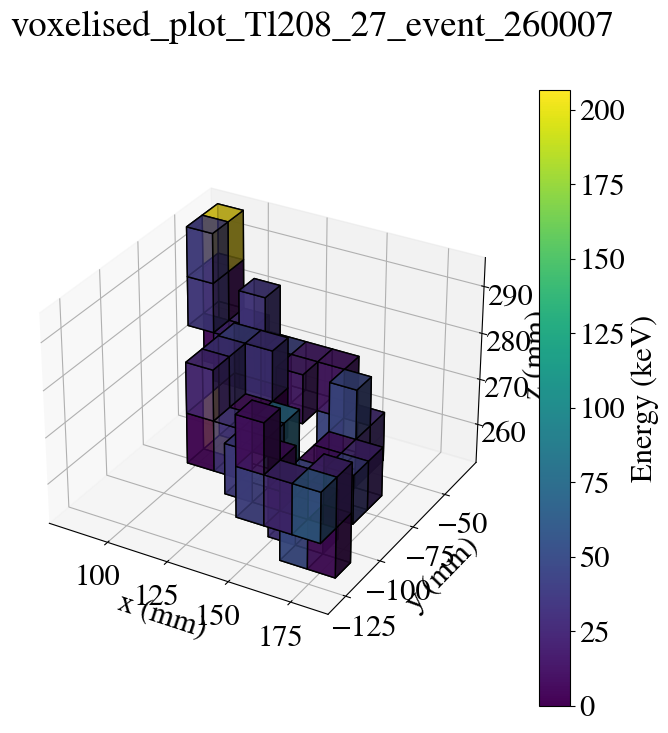

In [23]:
base_vsize = 12 #mm
the_hits = []


xs = this_evt_true_info.x
ys = this_evt_true_info.y
zs = this_evt_true_info.z
es = this_evt_true_info.energy

for x, y, z, e in zip(xs, ys, zs, es):
    if np.isnan(e): continue
    h = Hit(0, Cluster(0, xy(x,y), xy(0,0), 0), z, e*1000, xy(0,0))
    the_hits.append(h)

voxels = voxelize_hits(the_hits,
                       np.array([base_vsize, base_vsize, base_vsize]), False)

vsizex = voxels[0].size[0]
vsizey = voxels[0].size[1]
vsizez = voxels[0].size[2]

min_corner_x = min(v.X for v in voxels) - vsizex/2.
min_corner_y = min(v.Y for v in voxels) - vsizey/2.
min_corner_z = min(v.Z for v in voxels) - vsizez/2.

x = [np.round(v.X/vsizex) for v in voxels]
y = [np.round(v.Y/vsizey) for v in voxels]
z = [np.round(v.Z/vsizez) for v in voxels]
e = [v.E for v in voxels]

x_min = int(min(x))
y_min = int(min(y))
z_min = int(min(z))

x_max = int(max(x))
y_max = int(max(y))
z_max = int(max(z))

#print(f'X min = {x_min}, X max = {x_max}')
#print(f'Y min = {y_min}, Y max = {y_max}')
#print(f'Z min = {z_min}, Z max = {z_max}')

VOXELS = np.zeros((x_max-x_min+1, y_max-y_min+1, z_max-z_min+1))
#print(VOXELS.shape)

# sort through the event set the "turn on" the hit voxels
cmap = cm.viridis
norm = Normalize(vmin=0, vmax=max(e))

colors = np.empty(VOXELS.shape, dtype=object)
for q in range(0,len(z)):
    VOXELS[int(x[q])-x_min][int(y[q])-y_min][int(z[q])-z_min] = 1
    colors[int(x[q])-x_min][int(y[q])-y_min][int(z[q])-z_min] = cmap(norm(e[q]))

# and plot everything
fig = plt.figure(figsize=(8,8))
ax = fig.gca(projection='3d')
#a,b,c is spacing in mm needs an extra dim
a,b,c = np.indices((x_max-x_min+2, y_max-y_min+2, z_max-z_min+2))
a = a*vsizex + min_corner_x
b = b*vsizey + min_corner_y
c = c*vsizez + min_corner_z

# a, b, c are the corners of the voxels
ax.voxels(a,b,c, VOXELS, facecolors=colors , edgecolor='k',alpha=0.8)

ax.set_xlabel('x (mm)')#,fontsize=16)
ax.set_ylabel('y (mm)')#,fontsize=16)
ax.set_zlabel('z (mm)')#,fontsize=16)


sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cb = fig.colorbar(sm)
cb.set_label('Energy (keV)')

fig.suptitle('voxelised_plot_' + dir_name)
plt.show()

In [10]:
df_ps = pd.read_hdf(soph_file, 'MC/particles')
df_ps = df_ps[df_ps.event_id == evt/2]

def return_id(number):
    return str(df_ps[df_ps.particle_id == number].particle_name.values).strip("'[]'")

#df_ps = pd.read_hdf(soph_file, 'MC/particles')
#df_ps = df_ps[df_ps.event_id == evt/2]
#display(str(df_ps[df_ps.particle_id == 40].particle_name.values).strip("'[]'"))
#display(this_evt_true_info)
#display(df_ps.head(50))

#for pid, df in this_evt_true_info.groupby('particle_id'):
this_evt_true_info['particle_name'] = this_evt_true_info['particle_id'].apply(return_id)
display(this_evt_true_info)

/tmp/ipykernel_899192/556736396.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  this_evt_true_info['particle_name'] = this_evt_true_info['particle_id'].apply(return_id)


,event_id,particle_id,hit_id,x,y,z,time,energy,label,particle_name
2873,520014,26,0,182.407074,-119.473282,271.677399,2.225528,0.000019,ACTIVE,Xe131
2874,520014,25,0,181.922989,-120.064018,271.036713,2.060107,0.001491,ACTIVE,e+
2875,520014,25,1,181.484909,-120.611244,270.343353,2.063638,0.000316,ACTIVE,e+
2876,520014,25,2,181.138397,-121.226753,269.655487,2.067169,0.003888,ACTIVE,e+
2877,520014,25,3,180.685638,-121.794159,268.988434,2.070701,0.001564,ACTIVE,e+
...,...,...,...,...,...,...,...,...,...,...
3390,520014,44,7,139.916702,-95.556442,268.934570,2.396790,0.001756,ACTIVE,e-
3391,520014,44,8,139.881714,-95.578346,268.939453,2.397384,0.001486,ACTIVE,e-
3392,520014,44,9,139.872070,-95.598763,268.912354,2.397916,0.007674,ACTIVE,e-
3393,520014,44,10,139.872757,-95.598480,268.902618,2.398144,0.003133,ACTIVE,e-


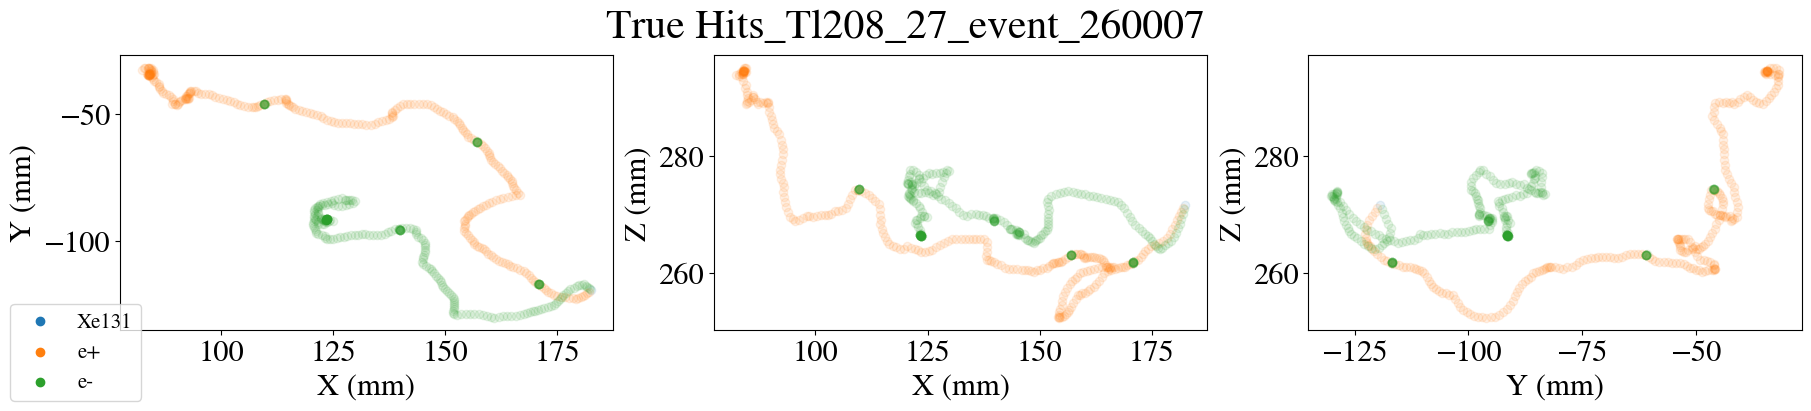

In [12]:

fig, axes = plt.subplots(1, 3, figsize=(18, 4), constrained_layout=True)
fig.suptitle('True Hits_' + dir_name, fontsize=30)
#fig.tight_layout()
added_labels = set()
# Dictionary to store custom handles for the legend
legend_handles = {}
for pid, df in this_evt_true_info.groupby('particle_name'):

    xt = df.x
    yt = df.y
    zt = df.z
    et = df.energy*1000


    axes[0].scatter(xt, yt,  alpha=0.1, label = str(pid))
    axes[1].scatter(xt, zt,  alpha=0.1, label = str(pid))
    axes[2].scatter(yt, zt,  alpha=0.1, label = str(pid))


    axes[0].set_xlabel('X (mm)');
    axes[0].set_ylabel('Y (mm)');
    axes[1].set_xlabel('X (mm)');
    axes[1].set_ylabel('Z (mm)');
    axes[2].set_xlabel('Y (mm)');
    axes[2].set_ylabel('Z (mm)');

# Retrieve legend handles and labels
handles, labels = axes[0].get_legend_handles_labels()

# Create a single legend for all subplots
legend = fig.legend(handles, labels, fontsize=15, loc = 'lower left')
for handle in legend.legendHandles:
    handle.set_alpha(1.0)

plt.show()

## now to scan over the tracks

In [9]:
if (datatype == 'MC'):
    evtmap = mcio.load_eventnumbermap(soph_file).set_index('nexus_evt')
    true_info = mcio.load_mchits_df(soph_file).reset_index()
    true_info.event_id = true_info.event_id.map(evtmap.evt_number)

# satellite killer
event_ids = []

r_lim = 415
z_upper = 1170
z_lower = 20





file_number = 27 # alter this
q = 0
cap = len(hdst.event.unique())

# this line applies the satellite killer
deconv_params_['satellite_iter'] = 5

# true track number
true_trk_number = []
time_spent = []
track_number = []

for i in range(len(hdst.event.unique())):
    print("event {},{}/{}".format(hdst.event.unique()[i],q, cap))
    q += 1
    if (q == cap):
        break
        
    #evt = int(saved_signal_evts[i]*2)
    evt = hdst.event.unique()[i]
    # signal events is the lower half
    dir_name = "plots/" + "event_" + str(hdst.event.unique()[i]) + "_file_" + str(file_number)
    if not os.path.exists(dir_name + '/iterations'):
        os.makedirs(dir_name + '/iterations', exist_ok = True)
    

    
    hits = hdst[hdst.event == evt]
    
    
    
    x_range, y_range, z_range, mid_x, mid_y, mid_z, min_x, min_y, min_z, max_x, max_y, max_z, xbins, ybins, zbins = collect_min_max_bins(hits)
    
 
    
    hits_cut = coref.timefunc(cut_sensors)(hits.copy())
    hits_drop = coref.timefunc(drop_sensors)(hits_cut.copy())
    
    # this is to stop your number of iterations vanishing because of the below function, as you're rewriting deconv_params_
    if 'save_state' in locals():
        deconv_params_['n_iterations'] = save_state
    else:
        # first time round, so set it
        save_state = deconv_params_['n_iterations']

    iter_E = []
    iter_no = []
    i = 0
    p = 0

    deconvolver = beerfun.deconvolve_signal(DataSiPM(detector_db, run_number), **deconv_params_)
        
    t0 = time.time()

    hits_deco = coref.timefunc(deconvolver)(hits_drop.copy())

    

    
    # Z
    z_max = hits_deco.Z.max()
    z_min = hits_deco.Z.min()
    
    # Radius
    r = np.sqrt(hits_deco.X**2 + hits_deco.Y**2)
    r_max = r.max()

    if ((z_max > z_upper) or (z_min < z_lower) or (r_max > r_lim)):
        
        print("Max reached at: {}, {}, {}".format(z_max, z_min, r_max))
    else:
        
        time_spent.append(time.time() - t0)
        
        
        # plot the MC
        
               # load in MC
        evtmap = mcio.load_eventnumbermap(soph_file).set_index('nexus_evt')
        true_info = mcio.load_mchits_df(soph_file).reset_index()
        true_info.event_id = true_info.event_id.map(evtmap.evt_number)


        this_evt_true_info = true_info[true_info.event_id == evt]

        xtMC = this_evt_true_info.x
        ytMC = this_evt_true_info.y
        ztMC = this_evt_true_info.z
        etMC = this_evt_true_info.energy*1000
        
        # collect true track number here
        true_trk_number.append(count_tracks_mc(this_evt_true_info))

        df_ps = pd.read_hdf(soph_file, 'MC/particles')
        df_ps = df_ps[df_ps.event_id == evt/2]

        #for pid, df in this_evt_true_info.groupby('particle_id'):
        this_evt_true_info['particle_name'] = this_evt_true_info['particle_id'].apply(return_id)

        fug, axus = plt.subplots(1, 3, figsize=(18, 4), constrained_layout=True)
        fug.suptitle('True Hits_' + dir_name, fontsize=30)
        #fig.tight_layout()
        added_labels = set()
        # Dictionary to store custom handles for the legend
        legend_handles = {}
        for pid, df in this_evt_true_info.groupby('particle_name'):

            xt = df.x
            yt = df.y
            zt = df.z
            et = df.energy*1000


            axus[0].scatter(xt, yt,  alpha=0.1, label = str(pid))
            axus[1].scatter(xt, zt,  alpha=0.1, label = str(pid))
            axus[2].scatter(yt, zt,  alpha=0.1, label = str(pid))


            axus[0].set_xlabel('X (mm)');
            axus[0].set_ylabel('Y (mm)');
            axus[1].set_xlabel('X (mm)');
            axus[1].set_ylabel('Z (mm)');
            axus[2].set_xlabel('Y (mm)');
            axus[2].set_ylabel('Z (mm)');

        # Retrieve legend handles and labels
        handles, labels = axus[0].get_legend_handles_labels()

        # Create a single legend for all subplots
        legend = fug.legend(handles, labels, fontsize=15, loc = 'lower left')
        for handle in legend.legendHandles:
            handle.set_alpha(1.0)

        fug.savefig(dir_name + '/MC_true.png')
        plt.close(fug)
        
        
        
        # if its within fiducial, keep it
        event_ids.append(evt)
        
        
        x = hits_deco.X
        y = hits_deco.Y
        z = hits_deco.Z
        e = hits_deco.E

        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        p = ax.scatter(x, y, z, c=e, alpha=0.07, cmap='viridis')
        cb = fig.colorbar(p, ax=ax)
        cb.set_label('Energy (keV)')

        ax.scatter(xtMC, ytMC, ztMC, color='red')
        
        ax.set_xlabel('x (mm)')
        ax.set_ylabel('y (mm)')
        ax.set_zlabel('z (mm)')

        fig.suptitle('3D_deconvolved_' + str(int(evt/2)) + "_iteration " + str(deconv_params_['n_iterations']), fontsize=30)
        #fig.savefig(pre_dir_name + dir_name +  "/3D_deconvolved_plot")
        fig.savefig(dir_name + '/iterations/3D_plot_' + str(deconv_params_['n_iterations']) + '_iter.png')
        plt.close(fig)

        # stick track number on after finishing
        track_number.append(count_tracks(hits_deco))



event 520000,0/316
Time spent in cut_over_Q: 0.02274322509765625 s
Time spent in drop_isolated: 0.020290613174438477 s
Time spent in apply_deconvolution: 3.1232008934020996 s


/tmp/ipykernel_1627996/1352907552.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  this_evt_true_info['particle_name'] = this_evt_true_info['particle_id'].apply(return_id)


event 520002,1/316
Time spent in cut_over_Q: 0.014329910278320312 s
Time spent in drop_isolated: 0.01941704750061035 s
Time spent in apply_deconvolution: 11.631104469299316 s
Max reached at: 479.05022812500005, 366.4473750000001, 485.4592117263818
event 520004,2/316
Time spent in cut_over_Q: 0.021844863891601562 s
Time spent in drop_isolated: 0.015957355499267578 s
Time spent in apply_deconvolution: 1.7495148181915283 s
Max reached at: 77.669771484375, 50.861848242187506, 418.6779744027622
event 520006,3/316
Time spent in cut_over_Q: 0.012830734252929688 s
Time spent in drop_isolated: 0.01573944091796875 s
Time spent in apply_deconvolution: 7.875417947769165 s
Max reached at: 617.4897750000001, 542.432165625, 484.8988515659735
event 520008,4/316
Time spent in cut_over_Q: 0.020454883575439453 s
Time spent in drop_isolated: 0.01919078826904297 s
Time spent in apply_deconvolution: 5.464454650878906 s
Max reached at: 562.7484843750001, 450.13847812500006, 498.27155874081353
event 520010,5/

In [63]:
print(track_number)
print(true_trk_number)

np.save('track_num_sat_kill.npy', track_number)
np.save('true_track_num_sat_kill.npy', true_trk_number)

[2, 2, 1, 4, 2, 2, 2, 2, 2, 1, 3, 2, 5, 1, 2, 1, 2, 5, 5, 1, 1, 2, 2, 1, 2, 1, 3, 5, 1, 1, 1, 3, 2, 6, 3, 2, 1, 3, 2, 1, 1, 1, 6, 3, 6, 2, 2, 1, 4, 1, 4, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 3, 1, 9, 2, 1, 5, 1, 1, 7, 1, 1, 2, 1, 1, 1, 1, 1, 1, 6, 1, 1, 2, 5, 3, 1, 1, 1, 2, 3, 5, 3, 3, 2, 4, 2, 1, 4, 4, 3, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 2, 6, 1, 1, 2, 2, 1, 1, 2, 5, 1, 1, 5, 3, 4, 3, 2, 1, 3, 3, 1, 1, 4]
[1, 2, 1, 2, 1, 1, 2, 2, 2, 1, 1, 3, 3, 1, 2, 1, 2, 3, 4, 1, 1, 2, 2, 1, 2, 2, 1, 3, 1, 1, 1, 3, 2, 2, 2, 2, 1, 3, 2, 2, 1, 1, 4, 2, 4, 2, 3, 1, 4, 1, 3, 1, 1, 1, 3, 1, 1, 1, 1, 2, 1, 2, 1, 3, 2, 1, 3, 1, 1, 3, 1, 1, 2, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 3, 1, 1, 1, 1, 2, 2, 4, 3, 2, 2, 2, 3, 1, 4, 3, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 2, 5, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 4, 3, 4, 3, 2, 1, 3, 2, 1, 1, 1]


Text(0, 0.5, 'Reco number of tracks')

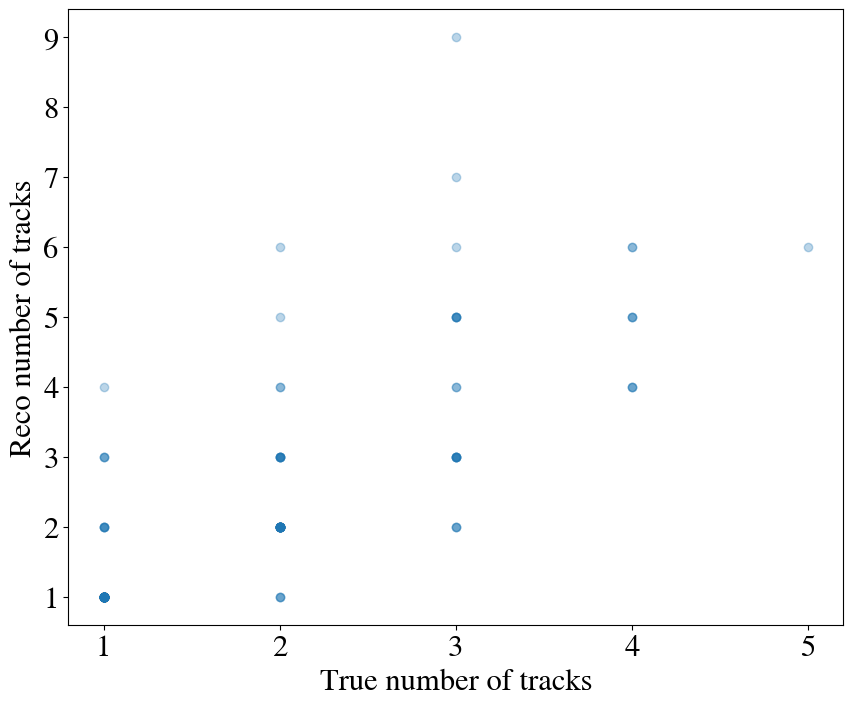

In [49]:
plt.scatter(true_trk_number, track_number, alpha = 0.3)
plt.xlabel("True number of tracks")
plt.ylabel("Reco number of tracks")

Text(0, 0.5, 'count')

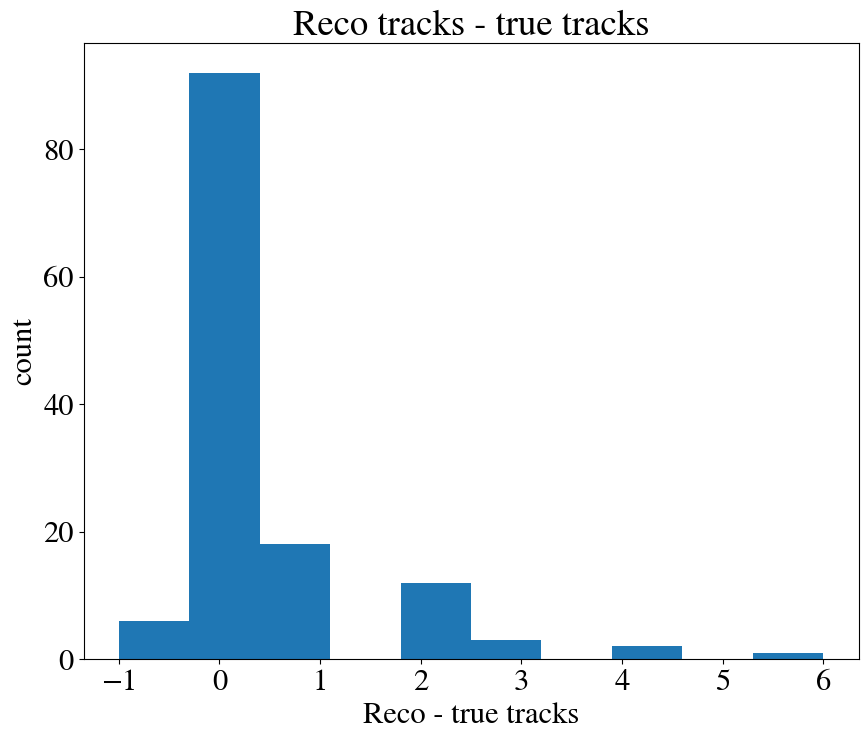

In [40]:
plt.hist([a - b for a, b in zip(track_number, true_trk_number)])
plt.title('Reco tracks - true tracks')
plt.xlabel('Reco - true tracks')
plt.ylabel('count')

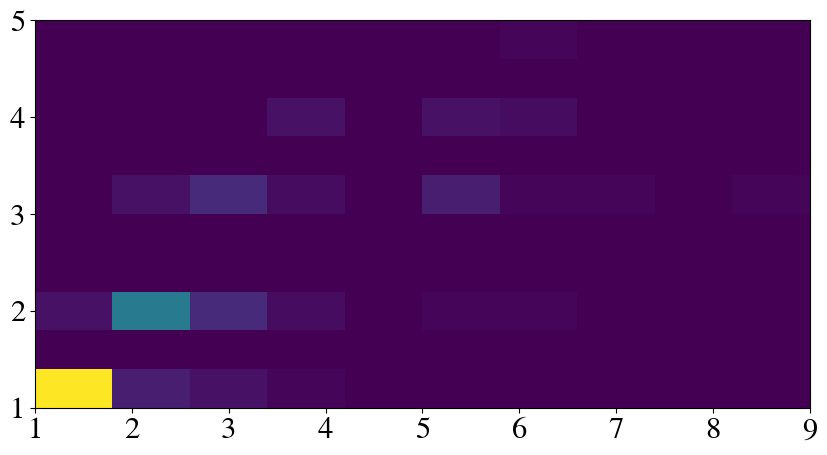

In [48]:
heatmap, xedges, yedges = np.histogram2d(track_number, true_trk_number, bins = 10)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='lower', vmin = 0.1)
plt.show()

In [50]:
if (datatype == 'MC'):
    evtmap = mcio.load_eventnumbermap(soph_file).set_index('nexus_evt')
    true_info = mcio.load_mchits_df(soph_file).reset_index()
    true_info.event_id = true_info.event_id.map(evtmap.evt_number)

# satellite killer
event_ids = []

r_lim = 415
z_upper = 1170
z_lower = 20





file_number = 27 # alter this
q = 0
cap = len(hdst.event.unique())

# this line applies the satellite killer
deconv_params_['satellite_iter'] = 9999

# true track number
true_trk_number_no_sat = []
time_spent = []
track_number_no_sat = []

for i in range(len(hdst.event.unique())):
    print("event {},{}/{}".format(hdst.event.unique()[i],q, cap))
    q += 1
    if (q == cap):
        break
        
    #evt = int(saved_signal_evts[i]*2)
    evt = hdst.event.unique()[i]
    # signal events is the lower half
    dir_name = "plots/" + "event_" + str(hdst.event.unique()[i]) + "_file_" + str(file_number)
    if not os.path.exists(dir_name + '/iterations'):
        os.makedirs(dir_name + '/iterations', exist_ok = True)
    

    
    hits = hdst[hdst.event == evt]
    
    
    
    x_range, y_range, z_range, mid_x, mid_y, mid_z, min_x, min_y, min_z, max_x, max_y, max_z, xbins, ybins, zbins = collect_min_max_bins(hits)
    
 
    
    hits_cut = coref.timefunc(cut_sensors)(hits.copy())
    hits_drop = coref.timefunc(drop_sensors)(hits_cut.copy())
    
    # this is to stop your number of iterations vanishing because of the below function, as you're rewriting deconv_params_
    if 'save_state' in locals():
        deconv_params_['n_iterations'] = save_state
    else:
        # first time round, so set it
        save_state = deconv_params_['n_iterations']

    iter_E = []
    iter_no = []
    i = 0
    p = 0

    deconvolver = beerfun.deconvolve_signal(DataSiPM(detector_db, run_number), **deconv_params_)
        
    t0 = time.time()

    hits_deco = coref.timefunc(deconvolver)(hits_drop.copy())

    

    
    # Z
    z_max = hits_deco.Z.max()
    z_min = hits_deco.Z.min()
    
    # Radius
    r = np.sqrt(hits_deco.X**2 + hits_deco.Y**2)
    r_max = r.max()

    if ((z_max > z_upper) or (z_min < z_lower) or (r_max > r_lim)):
        
        print("Max reached at: {}, {}, {}".format(z_max, z_min, r_max))
    else:
        
        time_spent.append(time.time() - t0)
        
        
        # plot the MC
        
               # load in MC
        evtmap = mcio.load_eventnumbermap(soph_file).set_index('nexus_evt')
        true_info = mcio.load_mchits_df(soph_file).reset_index()
        true_info.event_id = true_info.event_id.map(evtmap.evt_number)


        this_evt_true_info = true_info[true_info.event_id == evt]

        xtMC = this_evt_true_info.x
        ytMC = this_evt_true_info.y
        ztMC = this_evt_true_info.z
        etMC = this_evt_true_info.energy*1000
        
        # collect true track number here
        true_trk_number_no_sat.append(count_tracks_mc(this_evt_true_info))

        df_ps = pd.read_hdf(soph_file, 'MC/particles')
        df_ps = df_ps[df_ps.event_id == evt/2]

        #for pid, df in this_evt_true_info.groupby('particle_id'):
        this_evt_true_info['particle_name'] = this_evt_true_info['particle_id'].apply(return_id)

        fug, axus = plt.subplots(1, 3, figsize=(18, 4), constrained_layout=True)
        fug.suptitle('True Hits_' + dir_name, fontsize=30)
        #fig.tight_layout()
        added_labels = set()
        # Dictionary to store custom handles for the legend
        legend_handles = {}
        for pid, df in this_evt_true_info.groupby('particle_name'):

            xt = df.x
            yt = df.y
            zt = df.z
            et = df.energy*1000


            axus[0].scatter(xt, yt,  alpha=0.1, label = str(pid))
            axus[1].scatter(xt, zt,  alpha=0.1, label = str(pid))
            axus[2].scatter(yt, zt,  alpha=0.1, label = str(pid))


            axus[0].set_xlabel('X (mm)');
            axus[0].set_ylabel('Y (mm)');
            axus[1].set_xlabel('X (mm)');
            axus[1].set_ylabel('Z (mm)');
            axus[2].set_xlabel('Y (mm)');
            axus[2].set_ylabel('Z (mm)');

        # Retrieve legend handles and labels
        handles, labels = axus[0].get_legend_handles_labels()

        # Create a single legend for all subplots
        legend = fug.legend(handles, labels, fontsize=15, loc = 'lower left')
        for handle in legend.legendHandles:
            handle.set_alpha(1.0)

        fug.savefig(dir_name + '/MC_true.png')
        plt.close(fug)
        
        
        
        # if its within fiducial, keep it
        event_ids.append(evt)
        
        
        x = hits_deco.X
        y = hits_deco.Y
        z = hits_deco.Z
        e = hits_deco.E

        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        p = ax.scatter(x, y, z, c=e, alpha=0.07, cmap='viridis')
        cb = fig.colorbar(p, ax=ax)
        cb.set_label('Energy (keV)')

        ax.scatter(xtMC, ytMC, ztMC, color='red')
        
        ax.set_xlabel('x (mm)')
        ax.set_ylabel('y (mm)')
        ax.set_zlabel('z (mm)')

        fig.suptitle('3D_deconvolved_' + str(int(evt/2)) + "_iteration " + str(deconv_params_['n_iterations']), fontsize=30)
        #fig.savefig(pre_dir_name + dir_name +  "/3D_deconvolved_plot")
        fig.savefig(dir_name + '/iterations/3D_plot_' + str(deconv_params_['n_iterations']) + '_iter.png')
        plt.close(fig)

        # stick track number on after finishing
        track_number_no_sat.append(count_tracks(hits_deco))



event 520000,0/316
Time spent in cut_over_Q: 0.020496606826782227 s
Time spent in drop_isolated: 0.018600940704345703 s
Time spent in apply_deconvolution: 2.368403673171997 s


/tmp/ipykernel_899192/1848566874.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  this_evt_true_info['particle_name'] = this_evt_true_info['particle_id'].apply(return_id)


event 520002,1/316
Time spent in cut_over_Q: 0.010214805603027344 s
Time spent in drop_isolated: 0.015600204467773438 s
Time spent in apply_deconvolution: 8.818614721298218 s
Max reached at: 479.05022812500005, 366.4473750000001, 485.4592117263818
event 520004,2/316
Time spent in cut_over_Q: 0.01440119743347168 s
Time spent in drop_isolated: 0.011744022369384766 s
Time spent in apply_deconvolution: 1.3624053001403809 s
Max reached at: 77.669771484375, 50.861848242187506, 419.224398443125
event 520006,3/316
Time spent in cut_over_Q: 0.009567022323608398 s
Time spent in drop_isolated: 0.013285160064697266 s
Time spent in apply_deconvolution: 5.901695013046265 s
Max reached at: 617.4897750000001, 542.432165625, 484.8988515659735
event 520008,4/316
Time spent in cut_over_Q: 0.01805710792541504 s
Time spent in drop_isolated: 0.01763629913330078 s
Time spent in apply_deconvolution: 3.958266496658325 s
Max reached at: 562.7484843750001, 450.13847812500006, 498.27155874081353
event 520010,5/31

Text(0, 0.5, 'count')

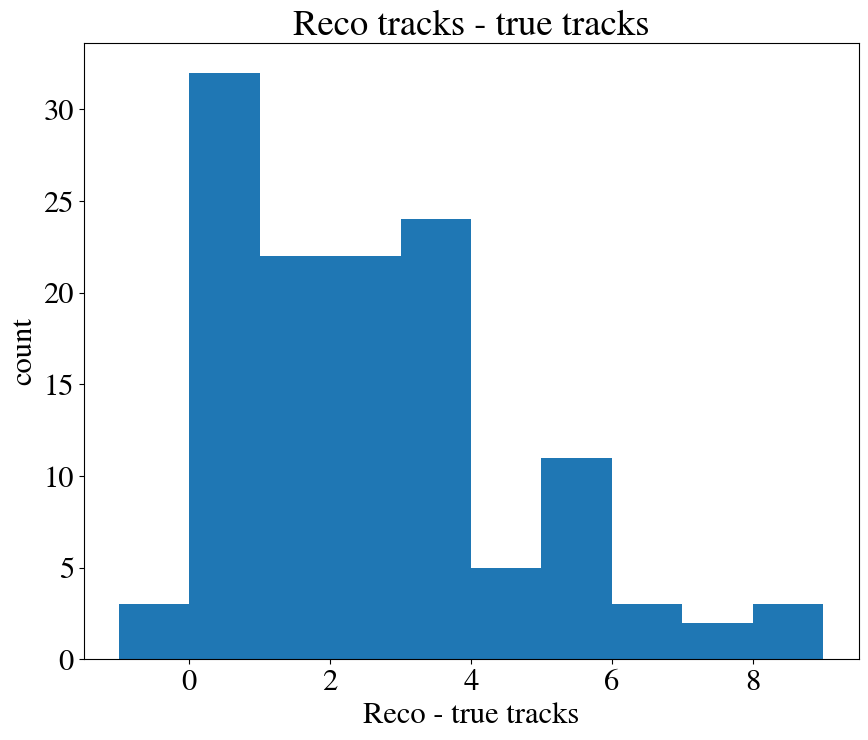

In [51]:
plt.hist([a - b for a, b in zip(track_number_no_sat, true_trk_number)])
plt.title('Reco tracks - true tracks')
plt.xlabel('Reco - true tracks')
plt.ylabel('count')

In [61]:
print(len(true_trk_number), len(track_number[:-7]), len(track_number_no_sat))

np.save('track_num_no_sat_kill.npy', track_number_no_sat)
np.save('true_track_num_no_sat_kill.npy', true_trk_number)

127 127 127


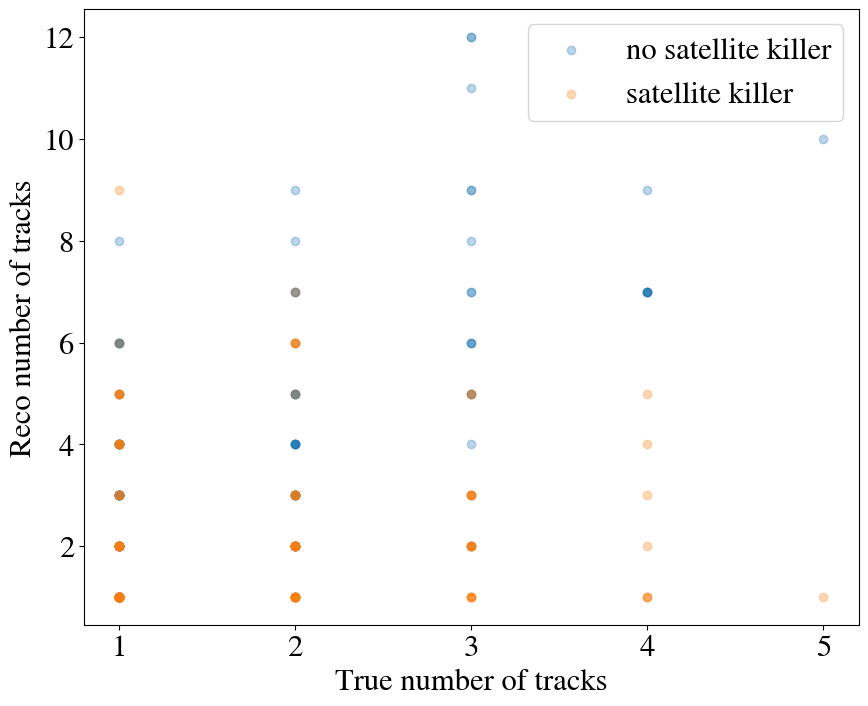

In [60]:
plt.scatter(true_trk_number, track_number_no_sat, alpha = 0.3, label = 'no satellite killer')
plt.scatter(true_trk_number, track_number[:-7], alpha = 0.3, label = 'satellite killer')
plt.xlabel("True number of tracks")
plt.ylabel("Reco number of tracks")
plt.legend()

In [3]:
trk_num_true_sat = np.load('true_track_num_sat_kill.npy')
trk_num_sat = np.load('track_num_sat_kill.npy')
trk_num_true_no_sat = np.load('true_track_num_no_sat_kill.npy')
trk_num_no_sat = np.load('track_num_no_sat_kill.npy')

Text(0, 0.5, 'count')

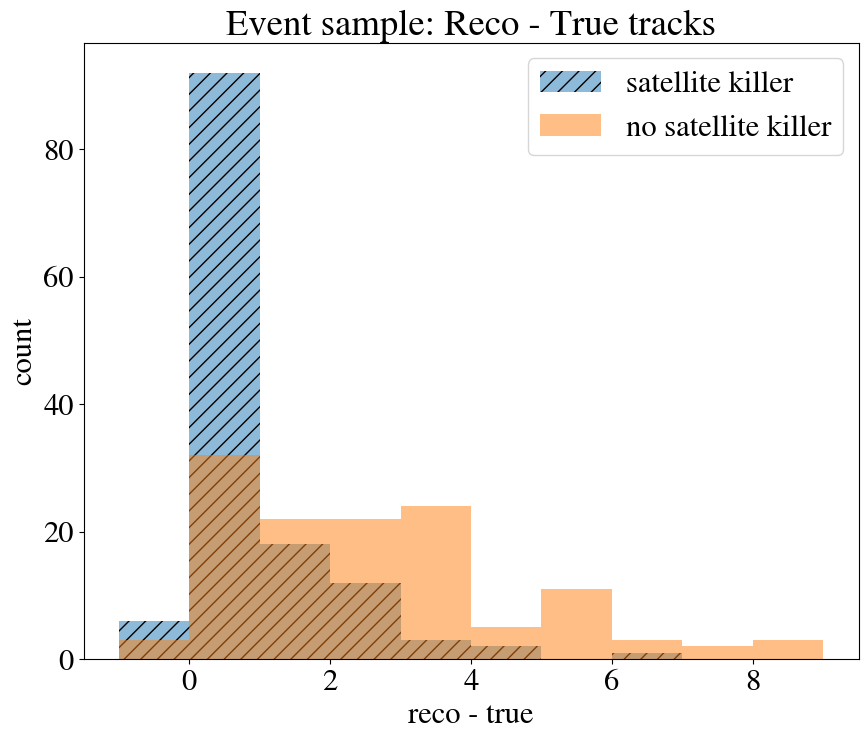

In [9]:
# FIX THE RANGES
q = np.array([a - b for a, b in zip(trk_num_sat, trk_num_true_sat)])
p = np.array([a - b for a, b in zip(trk_num_no_sat, trk_num_true_no_sat)])
plt.hist(q, label = 'satellite killer', alpha = 0.5, range = (np.min(q), np.max(p)), hatch = '//')
plt.hist(p, label = 'no satellite killer', alpha = 0.5, range = (np.min(p), np.max(p)))
plt.title('Event sample: Reco - True tracks')
plt.xlabel('reco - true')
plt.legend()
plt.ylabel('count')